# Image decompression and azimuthal integration on the GPU

This tutorial explains how it is possible to speed-up azimuthal integration by speeding-up the critical part: the data transfer to the GPU.

For this tutorial, a very recent version of `silx` is needed, newer than fall 2022 (available in release 1.2)

**Credits:**

* Thomas Vincent (ESRF) for the HDF5 direct chunk read and the Jupyter-slurm
* Jon Wright (ESRF) for the initial prototype of the bitshuffle-LZ4 decompression on the GPU
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs

**Nota:** a (fast) GPU is needed for this tutorial with OpenCL properly setup !

The example taken here is the same as the multithreading example: 4096 frames of Eiger_4M

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

In [2]:
import sys, os, collections, struct, time
import numpy, pyFAI
import h5py, hdf5plugin
from matplotlib.pyplot import subplots
import bitshuffle
import pyopencl.array as cla
import silx
from silx.opencl import ocl
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
start_time = time.time()
ocl

OpenCL devices:
[0] Portable Computing Language: (0,0) pthread-POWER9, altivec supported, (0,1) Tesla V100-SXM2-32GB, (0,2) Tesla V100-SXM2-32GB
[1] NVIDIA CUDA: (1,0) Tesla V100-SXM2-32GB, (1,1) Tesla V100-SXM2-32GB

In [3]:
#Here we select the OpenCL device
target = (0,1)

## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [4]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.config

HDF5PluginBuildOptions(openmp=False, native=False, sse2=True, avx2=False, cpp11=True, filter_file_extension='.so', embedded_filters=('blosc', 'bshuf', 'fcidecomp', 'lz4', 'zfp', 'zstd'))

In [5]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 34357.084


In [6]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [7]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

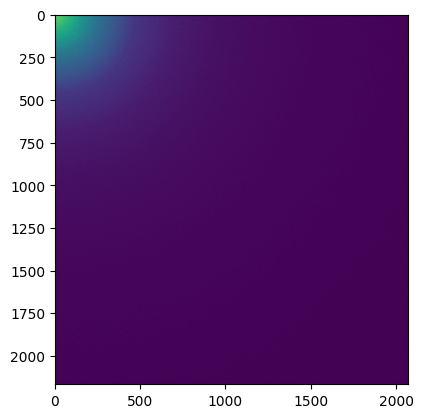

In [8]:
# display the image
fig,ax = subplots()
ax.imshow(frame)

In [9]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo:10s}:", end=" ")
    %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU")
print(f"Using algorithm {algo:10s}:", end=" ")
%timeit ai.integrate1d(img, nbins, method=("full", algo, "opencl", target))

Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU
Using algorithm histogram : 1.4 s ± 89.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc       : 64.9 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr       : 46.3 ms ± 5.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU
Using algorithm csr       : The slowest run took 39.06 times longer than the fastest. This could mean that an intermediate result is being cached.
37.4 ms ± 76.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

On the Power9 computer the CPU is much slower than the GPU !

In [10]:
# How is the time spend when integrating on GPU ?
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
engine.events = []
engine.set_profiling(True)
omega_crc = engine.on_device["solidangle"]
%timeit engine.integrate_ng(img, solidangle=omega, solidangle_checksum=omega_crc)
print("\n".join(engine.log_profile(stats=True)))
engine.set_profiling(False)
engine.events = []

6.22 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_CSR_Integrator
                                       Kernel name (count):      min   median      max     mean      std
                                   copy H->D image (  811):    1.482    1.539    1.693    1.544    0.033
                                         memset_ng (  811):    0.020    0.021    0.039    0.022    0.002
                                      corrections4 (  811):    0.244    0.246    0.260    0.246    0.001
                                    csr_integrate4 (  811):    0.525    0.529    0.533    0.529    0.001
                                  copy D->H avgint (  811):    0.014    0.020    0.064    0.019    0.004
                                     copy D->H std (  811):    0.016    0.018    0.029    0.018    0.001
                                     copy D->H sem (  811):    0.016    0.018    0.080    0.017    0.003
            

**Note:** Most of the time is spent in the transfer from the CPU to the GPU.

In [11]:
%%timeit -r1 -n1 -o -q
#Saving of a HDF5 file with many frames ...
with h5py.File(filename, "w") as h:
    ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
    for i in range(nbframes):
        ds[i] = frame + i%500 #Each frame has a different value to prevent caching effects

<TimeitResult : 1min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [12]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data, or {nbframes/timing_write.best:.3f} fps.")

File size 9.240 GB with a compression ratio of 7.408x
Write speed: 847.387 MB/s of uncompressed data, or 47.227 fps.


In [13]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 1min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [14]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data, or {nbframes/timing_read1.best:.3f} fps.")

Read speed: 920.013 MB/s of uncompressed data, or 51.275 fps.


In [15]:
# Time for decompressing one frame:
chunk = bitshuffle.compress_lz4(frame,0)
print(f"Compression ratio: {frame.nbytes/len(chunk):.3f}x")
timing_decompress = %timeit -o bitshuffle.decompress_lz4(chunk, frame.shape, frame.dtype, 0)
print(f"Decompression speed: {1/timing_decompress.best:.3f} fps")

Compression ratio: 9.099x
10.5 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Decompression speed: 127.868 fps


In [16]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 1.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [17]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps.")

Read speed: 5550.975 MB/s of compressed data.
HDF5 read speed (without decompression): 2291.770 fps.


## Prepare the azimuthal integrator
To unleash the full performances of the azimuthal integrator, here the ability to deal with GPU arrays, one needs to extract the OpenCL integrator from AzimuthalIntegator. The integrator used here is a sparse matrix multiplication one with a CSR representation, tuned to run on the GPU.

In [18]:
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
#This is how the engine works. First send the image on the GPU:

frame_d = cla.to_device(engine.queue, frame)
omega_crc = engine.on_device["solidangle"]

res1 = engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
assert numpy.allclose(res0.intensity, res1.intensity)  # validates the equivalence of both approaches:
timing_integration = %timeit -r3 -o engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
print(f"The maximum achievable integration speed on this device is {1/timing_integration.best:.3f} fps.")

1.22 ms ± 67.9 ns per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
The maximum achievable integration speed on this device is 819.520 fps.


In [19]:
timimg_sum = timing_integration.best + timing_read2.best/nbframes+timing_decompress.best
print(f"The maximum throughput considering reading, decompression and integration is {1/timimg_sum:.3f} fps.")

The maximum throughput considering reading, decompression and integration is 105.517 fps.


**Summary:**
* Read speed: 2400 fps
* Read + decompress: 110 fps
* Read + decomperss + integrate: 95 fps.

## Using the decompression on the GPU

This feature requires silx 1.2 !

In [20]:
silx.version

'1.2.0-a0'

In [21]:
# Read one chunk
with h5py.File(filename, "r") as h:
    ds = h["data"]
    i=0
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

In [22]:
gpu_decompressor = BitshuffleLz4(len(chunk), frame.size, dtype=frame.dtype, ctx=engine.ctx)

In [23]:
#Tune the decompressor for the fastest speed:
for i in range(0, 11):
    j = 1<<i
    print(f"Workgroup size {j:3d} : ", end=" ")
    %timeit gpu_decompressor.decompress(chunk, wg=j)

Workgroup size   1 :  8.28 ms ± 365 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   2 :  5.51 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   4 :  2.98 ms ± 221 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   8 :  1.75 ms ± 238 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  16 :  1.14 ms ± 152 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  32 :  838 µs ± 33.8 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  64 :  724 µs ± 9.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 128 :  655 µs ± 79.9 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 256 :  664 µs ± 320 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 512 :  733 µs ± 42.6 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 1024 :  883 µs ± 46.3 ns per loop (mean ± 

In [24]:
#Set the workgroup size (called block in cuda) to the best value we found previoulsy
gpu_decompressor.block_size = 128 

In [25]:
#Tune the integrator for the fastest speed:

def new_engine(engine, wg):
    return engine.__class__((engine._data, engine._indices, engine._indptr), 
                              engine.size, empty=engine.empty, unit=engine.unit, 
                              bin_centers=engine.bin_centers, azim_centers = engine.azim_centers,  
                              ctx=engine.ctx, block_size=wg)
for i in range(0, 11):
    j = 1<<i
    print(f"Workgroup size {j:3d} : ", end=" ")
    ne = new_engine(engine, j)
    ne.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
    %timeit ne.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)

Workgroup size   1 :  11.8 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   2 :  7.63 ms ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   4 :  4.47 ms ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   8 :  2.82 ms ± 399 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size  16 :  1.82 ms ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  32 :  1.23 ms ± 457 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  64 :  1.04 ms ± 29.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 128 :  1.08 ms ± 25.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 256 :  1.05 ms ± 150 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 512 :  1.02 ms ± 305 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 1024 :  1.1 ms ± 29.6 µs per loop (mean

In [26]:
engine = new_engine(engine, 512)
%time engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
pass

CPU times: user 12.5 ms, sys: 64.1 ms, total: 76.5 ms
Wall time: 80.6 ms


In [27]:
#Build a pipeline with decompression and integration on the GPU:
%timeit engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc)

1.48 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
result = numpy.empty((nbframes, nbins), dtype=numpy.float32)

In [29]:
%%timeit -r1 -n1 -o -q
# Process a complete stack:
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
        result[i] = engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc).intensity

<TimeitResult : 9.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [30]:
timing_process_gpu = _
print(f"Processing speed when decompression occures on GPU: {nbframes/timing_process_gpu.best:.3f} fps which represents at speed-up of {timimg_sum*nbframes/timing_process_gpu.best:.3f}x.")

Processing speed when decompression occures on GPU: 428.141 fps which represents at speed-up of 4.058x.


## Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors with a pattern of 500 frames. 

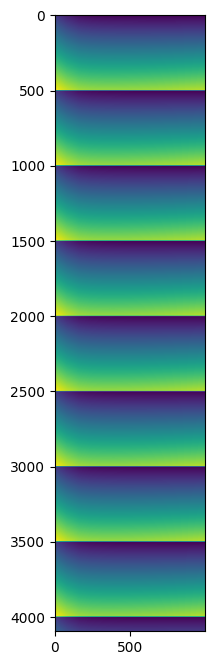

In [31]:
fig,ax = subplots(figsize=(8,8))
ax.imshow(result)

## Conclusion

Bitshuffle-LZ4 data decompression can be off-loaded to the GPU, this is especially appealing when downstream processing requires also GPU-computing like azimuthal integration.

The procedure is simpler than multi-threading approach: no queue, no threads, ... but requires a GPU (properly setup).

The performances measured on a (not so recent) Tesla V100 are similar to a much more recent RTX3080 which are the same as a 2x32-cores computer in multithreading: ~500 fps

Those performances can be further parallelized using multiprocessing if needed.

In [32]:
print(f"Total processing time: {time.time()-start_time:.3f} s")

Total processing time: 398.101 s
